In [5]:

import os

# (optional) update gcloud if needed
if os.getenv("IS_TESTING"):
    ! gcloud components update --quiet

! pip3 install --upgrade --quiet google-cloud-aiplatform



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 76.4 MB/s eta 0:00:00


In [6]:
import gc

In [3]:
import sys

if "google.colab" in sys.modules:

    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

In [1]:
#Implementing this would ask permission to allow Google account to be associated with this notebook and some other permission to steal data from you :)

import sys

if "google.colab" in sys.modules:

    from google.colab import auth

    auth.authenticate_user()

In [1]:
PROJECT_ID = "bot-retail2"  # @param {type:"string"}
LOCATION = "us-west1"  # @param {type: "string"}

In [2]:

# BUCKET_URI = "gs://retail-bot-senti-{PROJECT_ID}"
BUCKET_URI = f"gs://senti-{PROJECT_ID}-unique"


In [4]:
! gsutil mb -l {LOCATION} -p {PROJECT_ID} {BUCKET_URI}

Creating gs://senti-bot-retail2-unique/...


In [4]:
BUCKET_URI

'gs://senti-bot-retail2-unique'

In [3]:
#To associate with your specific service account

import os
STAGING_BUCKET = os.path.join(BUCKET_URI, "temporal")

# The service account looks like:
# '@.iam.gserviceaccount.com'
# Please go to https://cloud.google.com/iam/docs/service-accounts-create#iam-service-accounts-create-console
# and create service account with `Vertex AI User` and `Storage Object Admin` roles.
# The service account for deploying fine tuned model.
SERVICE_ACCOUNT = "149073596729-compute@developer.gserviceaccount.com"  # @param {type:"string"}


In [4]:

import os
from datetime import datetime, timedelta

from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=LOCATION, staging_bucket=STAGING_BUCKET)


In [9]:

VERTEX_AI_MODEL_GARDEN_LLAMA3 = "gs://vertex-model-garden-public-us/llama3"  # This will be shared once click the agreement of LLaMA2 in Vertex AI Model Garden.
VERTEX_MODEL_ID = "llama3-8b-hf"
HF_MODEL_ID = "meta-llama/Llama-3-8b-hf"



In [11]:

assert (
    VERTEX_AI_MODEL_GARDEN_LLAMA3
), "Please click the agreement of Llama 3 in Vertex AI Model Garden, and get the GCS path of Llama 3 model artifacts."
print(
    "Copy Llama 3 model artifacts from",
    VERTEX_AI_MODEL_GARDEN_LLAMA3,
    "to ",
    f"{BUCKET_URI}",
)

# Copy model files to your bucket
# ! gcloud storage cp -R VERTEX_AI_MODEL_GARDEN_LLAMA3/VERTEX_MODEL_ID/* {BUCKET_URI}/{HF_MODEL_ID}/

Copy Llama 3 model artifacts from gs://vertex-model-garden-public-us/llama3 to  gs://senti-bot-retail2-unique


In [12]:
!gsutil -m cp -R gs://vertex-model-garden-public-us/llama3 {BUCKET_URI}/{HF_MODEL_ID}/

Copying gs://vertex-model-garden-public-us/llama3/Meta-Llama-Guard-2-8B/LICENSE [Content-Type=application/octet-stream]...
Copying gs://vertex-model-garden-public-us/llama3/Meta-Llama-Guard-2-8B/README.md [Content-Type=text/markdown]...
Copying gs://vertex-model-garden-public-us/llama3/Meta-Llama-Guard-2-8B/USE_POLICY.md [Content-Type=text/markdown]...
Copying gs://vertex-model-garden-public-us/llama3/Meta-Llama-Guard-2-8B/config.json [Content-Type=application/json]...
Copying gs://vertex-model-garden-public-us/llama3/Meta-Llama-Guard-2-8B/generation_config.json [Content-Type=application/json]...
Copying gs://vertex-model-garden-public-us/llama3/Meta-Llama-Guard-2-8B/model-00001-of-00004.safetensors [Content-Type=application/octet-stream]...
Copying gs://vertex-model-garden-public-us/llama3/Meta-Llama-Guard-2-8B/model-00002-of-00004.safetensors [Content-Type=application/octet-stream]...
Copying gs://vertex-model-garden-public-us/llama3/Meta-Llama-Guard-2-8B/model-00003-of-00004.safeten

## Create the artifact registry repository and set the custom docker image uri

In [5]:

REPOSITORY = "gpu-training-chatbot-repository-unique"


In [6]:

image_name_train = "llama3-8b-hf-lora-tuning-gpu"
hostname = f"{LOCATION}-docker.pkg.dev"
tag = "latest"


In [10]:
!pip3 install docker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 3.0 MB/s eta 0:00:00


In [16]:
!docker --version


/bin/bash: line 1: docker: command not found


In [12]:
# to understand the current path
!echo $PATH

/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin


In [13]:
!which docker-credential-gcloud

/tools/google-cloud-sdk/bin/docker-credential-gcloud


In [17]:
#If docker is properly installed then when you execute this command it should output this: /usr/local/bin/docker

!which docker

In [18]:
# After executing these two lines here I was able to see /usr/local/bin/docker outcome for this command: !which docker
# These two lines fixed the following error message:

# WARNING: `docker` not in system PATH.

# `docker` and `docker-credential-gcloud` need to be in the same PATH in order to work correctly together.

# gcloud's Docker credential helper can be configured but it will not work until this is corrected.WARNING: Your config file at [/root/.docker/config.json] contains these credential helper entries:



# {

#   "credHelpers": {

#     "us-west1-docker.pkg.dev": "gcloud"

#   }

# }

!touch /usr/local/bin/docker
!chmod +x /usr/local/bin/docker

In [18]:
# import os
# os.environ['PATH'] = "/usr/local/bin:" + os.environ['PATH']

In [19]:
# os.environ['PATH']

In [20]:
#after the error got fixed and when executed the following command I get to see the path
!which docker


/usr/local/bin/docker


In [21]:
import os

os.environ['PATH'] = "/usr/local/bin:/tools/google-cloud-sdk/bin:" + os.environ['PATH']

In [22]:
!echo $PATH

/usr/local/bin:/tools/google-cloud-sdk/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin


In [23]:
!gcloud config list

[component_manager]
disable_update_check = True
[core]
account = chidambaram.spv@gmail.com

Your active configuration is: [default]


In [24]:
#to set configurations for PROJECT_ID
!gcloud config set project {PROJECT_ID}


Updated property [core/project].


In [25]:
!gcloud --version

Google Cloud SDK 499.0.0


In [26]:
from google.colab import auth
auth.authenticate_user()

In [27]:
#The warning finally disappeared after fixing the docker is not in the path error. Otherwise you see a warning here. If you are not seeing that means that
# docker is properly isntalled and good to go

!gcloud auth configure-docker {LOCATION}-docker.pkg.dev --quiet

Adding credentials for: us-west1-docker.pkg.dev
Docker configuration file updated.


In [ ]:
# Maybe this is what I used last time to fix the error: docker is not in the path. Don't have to use it if there is no error
# import json

# # Read the current config
# with open('/root/.docker/config.json', 'r') as f:
#     config = json.load(f)

# # Add your region if it's not already there
# if f"{region}-docker.pkg.dev" not in config['credHelpers']:
#     config['credHelpers'][f"{region}-docker.pkg.dev"] = "gcloud"

# # Write the updated config
# with open('/root/.docker/config.json', 'w') as f:
#     json.dump(config, f)


In [28]:
REPOSITORY

'gpu-training-chatbot-repository-unique'

In [29]:
#Why we doing this?
# One time or use an existing repository
!echo "y" gcloud artifacts repositories create $REPOSITORY --repository-format=docker \
--location=$LOCATION --description="Vertex AI GPU training repository"


y gcloud artifacts repositories create gpu-training-chatbot-repository-unique --repository-format=docker --location=us-west1 --description=Vertex AI GPU training repository


In [33]:

# Define container image name
PYTORCH_TRAIN_DOCKER_URI = (
    f"{hostname}/{PROJECT_ID}/{REPOSITORY}/{image_name_train}:{tag}"
)


In [34]:
PYTORCH_TRAIN_DOCKER_URI

'us-west1-docker.pkg.dev/bot-retail2/gpu-training-chatbot-repository-unique/llama3-8b-hf-lora-tuning-gpu:latest'

In [35]:

def get_job_name_with_datetime(prefix: str) -> str:
    """Gets the job name with date time when triggering training or deployment
    jobs in Vertex AI.
    """
    return prefix + datetime.now().strftime("_%Y%m%d_%H%M%S")

In [36]:
import os

if not os.path.exists("trainer"):
    os.makedirs("trainer")

In [37]:
%%writefile trainer/Dockerfile
# This Dockerfile finetunes the Llamas3 model using LoRA with PyTorch XLA
# Nightly TPU VM docker image
FROM us-central1-docker.pkg.dev/tpu-pytorch-releases/docker/xla:nightly_3.10_tpuvm_20240324

ENV DEBIAN_FRONTEND=noninteractive

# Install basic libs
RUN apt-get update && apt-get -y upgrade && apt-get install -y --no-install-recommends \
        cmake \
        curl \
        wget \
        sudo \
        gnupg \
        libsm6 \
        libxext6 \
        libxrender-dev \
        lsb-release \
        ca-certificates \
        build-essential \
        git \
        libgl1

# Install required libs
RUN pip install --upgrade pip
RUN pip install --upgrade pip
RUN pip install transformers==4.38.2 -U
RUN pip install datasets==2.18.0
RUN pip install trl==0.8.1 peft==0.10.0
RUN pip install accelerate==0.28.0
RUN pip install --upgrade google-cloud-storage

# Copy other licenses.
RUN wget -O MIT_LICENSE https://github.com/pytest-dev/pytest/blob/main/LICENSE
RUN wget -O BSD_LICENSE https://github.com/pytorch/xla/blob/master/LICENSE
RUN wget -O BSD-3_LICENSE https://github.com/pytorch/pytorch/blob/main/LICENSE

# Copy install libtpu to PATH above
RUN find ./usr/local/lib -name 'libtpu.so' -exec cp {} /lib \;

WORKDIR /
COPY train.py train.py
ENV PYTHONPATH ./

ENTRYPOINT ["python", "train.py"]

Writing trainer/Dockerfile


In [38]:
!touch trainer/__init__.py

In [7]:
#This function here is to download and read a file from G storage
from google.colab import auth
from google.cloud import storage
import pandas as pd
import io

# Authenticate (if using Google Colab)
auth.authenticate_user()

def read_csv_from_gcs(bucket_name, file_name):
    # Initialize the Google Cloud Storage client
    client = storage.Client()

    # Get the bucket and blob
    bucket = client.get_bucket(bucket_name)
    blob = bucket.blob(file_name)

    # Download the contents of the blob as a string
    content = blob.download_as_text()

    # Use pandas to read the CSV content
    df = pd.read_csv(io.StringIO(content))

    return df




In [11]:

# implementing the above function: read_csv_from_gcs
bucket_name = 'senti-bot-retail2-unique'
file_name = 'preprocessed_with_instruction_input_output.csv'

df = read_csv_from_gcs(bucket_name, file_name)

In [12]:
df.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description,instruction,input,response
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...,What are the features of the product?,"['Garlic Oil - Vegetarian Capsule 500 mg', 'Be...",Garlic Oil - Vegetarian Capsule 500 mg belongs...
1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...,Does this product have any discount?,"[220.0, 220.0]",There is no discount on this product at the mo...
2,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...,How much does it cost?,220.0,The product costs $220.0
3,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...,What's its rating?,4.1,It has a rating of 4.1 out of 5.
4,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...,What's its brand?,Sri Sri Ayurveda,The product's brand is Sri Sri Ayurveda


In [104]:
df.isnull().sum()*100/len(df)

,0
product,0.003629
category,0.000000
sub_category,0.000000
brand,0.003629
sale_price,0.000000
market_price,0.000000
type,0.000000
rating,31.304663
description,0.417347
instruction,0.000000


In [13]:
len(df)

137775

In [14]:

# df.drop("index", axis=1, inplace=True)


In [14]:
#One form of transforming training data: combining all the fields
import re

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and extra whitespace
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def combine_fields(row):
    # Combine all fields into a single text
    combined_text = f"Product: {row['product']}"
    combined_text = f"category: {row['category']}"
    combined_text = f"Sub_category: {row['sub_category']}"
    combined_text = f"brand: {row['brand']}"
    combined_text += f"Sale_price: ${row['sale_price']:.2f}"
    combined_text += f"Market_price: ${row['market_price']:.2f}"
    combined_text += f"Type: {row['type']}"
    combined_text += f"Rating: {row['rating']} "
    combined_text += f"Description: {row['description']}"
    # Preprocess the combined text
    return preprocess_text(combined_text)



In [15]:

# Apply preprocessing to each row
df['preprocessed_text'] = df_.apply(combine_fields, axis=1)



In [16]:

df.head()


,product,category,sub_category,brand,sale_price,market_price,type,rating,description,preprocessed_text
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...,brand sri sri ayurveda saleprice 22000marketpr...
1,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ...",brand mastercooksaleprice 18000marketprice 180...
2,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m...",brand trmsaleprice 11900marketprice 25000type ...
3,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...,brand nakodasaleprice 14900marketprice 17600ty...
4,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...,brand niveasaleprice 16200marketprice 16200typ...


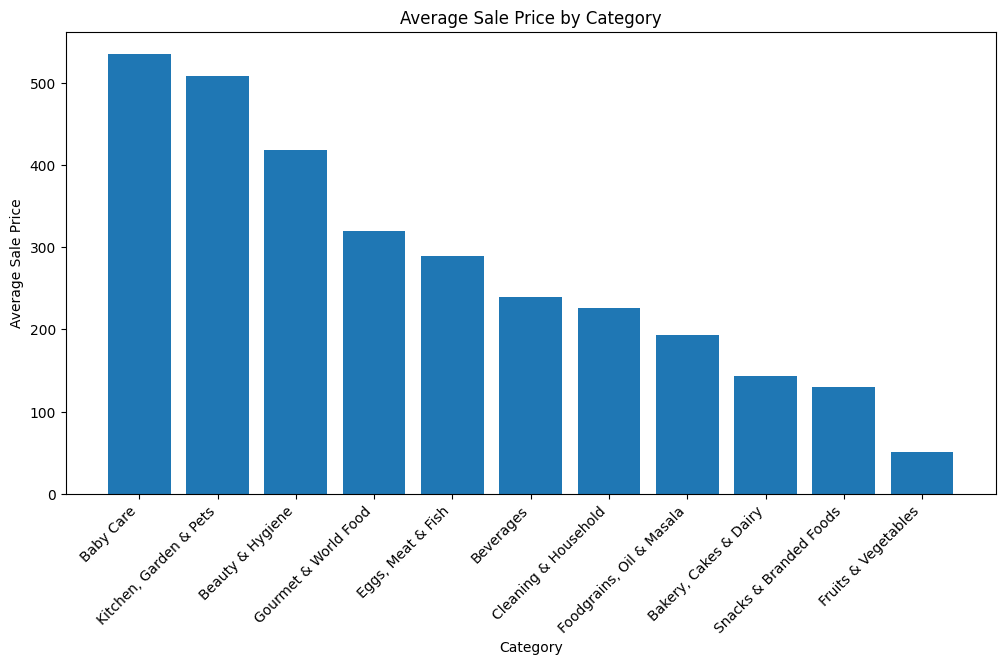

In [26]:
# @title Average Sale Price by Category

import matplotlib.pyplot as plt

# Assuming your data is in a pandas DataFrame called 'df_'
category_avg_prices = df_.groupby('category')['sale_price'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(category_avg_prices.index, category_avg_prices.values)
plt.xlabel('Category')
plt.ylabel('Average Sale Price')
plt.title('Average Sale Price by Category')
_ = plt.xticks(rotation=45, ha='right')

In [17]:

#Transforming the raw input data using special tags to highlight specific fields

def preprocess_data(df):
    """Preprocesses the product dataset for fine-tuning a LLaMA model.

    Args:
        df (pd.DataFrame): The input DataFrame with the specified columns.

    Returns:
        pd.DataFrame: The preprocessed DataFrame with a 'combined_text' column.
    """

    def combine_text_fields(row):
        """Combines text fields with special tokens."""
        return f"""
<p>{row['product']}</p>
<c>{row['category']}</c>
<sc>{row['sub_category']}</sc>
<br>{row['brand']}</br>
<sp>${row['sale_price']}</sp>
<mp>${row['market_price']}</mp>
<t>{row['type']}</t>
<r>{row['rating']} stars</r>
<d>{row['description']}</d>
"""

    # Apply the function to create the combined text column
    df['combined_text'] = df.apply(combine_text_fields, axis=1)

    # Additional text cleaning or formatting can be done here if needed
    # ...

    return df




In [18]:

# Preprocess the data
processed_df = preprocess_data(df_)


In [19]:
processed_df.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description,preprocessed_text,combined_text
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...,brand sri sri ayurveda saleprice 22000marketpr...,\n<p>Garlic Oil - Vegetarian Capsule 500 mg</p...
1,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ...",brand mastercooksaleprice 18000marketprice 180...,"\n<p>Water Bottle - Orange</p>\n<c>Kitchen, Ga..."
2,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m...",brand trmsaleprice 11900marketprice 25000type ...,"\n<p>Brass Angle Deep - Plain, No.2</p>\n<c>Cl..."
3,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...,brand nakodasaleprice 14900marketprice 17600ty...,\n<p>Cereal Flip Lid Container/Storage Jar - A...
4,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...,brand niveasaleprice 16200marketprice 16200typ...,\n<p>Creme Soft Soap - For Hands & Body</p>\n<...


In [25]:
#Transforming the raw input text into 'instruction', 'response' where they both are the same

def preprocess_data2(df):
    """Preprocesses the product dataset for fine-tuning a LLaMA model.

    Args:
        df (pd.DataFrame): The input DataFrame with the specified columns.

    Returns:
        pd.DataFrame: The preprocessed DataFrame with 'instruction' and 'response' columns.
    """

    def create_field_specific_pairs(row):
        """Generates instruction-response pairs for each field."""
        instructions = []
        responses = []

        instructions.append(f"Product: {row['product']}")
        responses.append(row['product'])

        instructions.append(f"Category: {row['category']}")
        responses.append(row['category'])

        instructions.append(f"Sub_category: {row['sub_category']}")
        responses.append(row['sub_category'])

        instructions.append(f"Brand: {row['brand']}")
        responses.append(row['brand'])

        instructions.append(f"Sale_price: ${row['sale_price']}")
        responses.append(str(row['sale_price']))  # Convert to string

        instructions.append(f"Market_price: ${row['market_price']}")
        responses.append(str(row['market_price']))  # Convert to string

        instructions.append(f"Type: {row['type']}")
        responses.append(row['type'])

        instructions.append(f"Rating: {row['rating']} stars")
        responses.append(str(row['rating']))  # Convert to string

        instructions.append(f"Description: {row['description']}")
        responses.append(row['description'])

        return instructions, responses

    # Create instruction-response pairs
    df[['instruction', 'response']] = df.apply(create_field_specific_pairs, axis=1, result_type='expand')

    # Explode the DataFrame to have one row per instruction-response pair
    df = df.explode(['instruction', 'response'])

    # Additional text cleaning and formatting can be done here if needed
    # ...

    return df



In [26]:
# Preprocess the data
processed_df_fair = preprocess_data2(processed_df)

In [27]:
processed_df_fair.head()


,product,category,sub_category,brand,sale_price,market_price,type,rating,description,preprocessed_text,combined_text,instruction,response
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...,brand sri sri ayurveda saleprice 22000marketpr...,\n<p>Garlic Oil - Vegetarian Capsule 500 mg</p...,Product: Garlic Oil - Vegetarian Capsule 500 mg,Garlic Oil - Vegetarian Capsule 500 mg
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...,brand sri sri ayurveda saleprice 22000marketpr...,\n<p>Garlic Oil - Vegetarian Capsule 500 mg</p...,Category: Beauty & Hygiene,Beauty & Hygiene
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...,brand sri sri ayurveda saleprice 22000marketpr...,\n<p>Garlic Oil - Vegetarian Capsule 500 mg</p...,Sub_category: Hair Care,Hair Care
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...,brand sri sri ayurveda saleprice 22000marketpr...,\n<p>Garlic Oil - Vegetarian Capsule 500 mg</p...,Brand: Sri Sri Ayurveda,Sri Sri Ayurveda
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...,brand sri sri ayurveda saleprice 22000marketpr...,\n<p>Garlic Oil - Vegetarian Capsule 500 mg</p...,Sale_price: $220.0,220.0


In [28]:
len(processed_df_fair)

247995

In [47]:
df.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description,preprocessed_text,combined_text,instruction,response
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...,brand sri sri ayurveda saleprice 22000marketpr...,\n<p>Garlic Oil - Vegetarian Capsule 500 mg</p...,['Product: Garlic Oil - Vegetarian Capsule 500...,"['Garlic Oil - Vegetarian Capsule 500 mg', 'Be..."
1,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ...",brand mastercooksaleprice 18000marketprice 180...,"\n<p>Water Bottle - Orange</p>\n<c>Kitchen, Ga...","['Product: Water Bottle - Orange', 'Category: ...","['Water Bottle - Orange', 'Kitchen, Garden & P..."
2,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m...",brand trmsaleprice 11900marketprice 25000type ...,"\n<p>Brass Angle Deep - Plain, No.2</p>\n<c>Cl...","['Product: Brass Angle Deep - Plain, No.2', 'C...","['Brass Angle Deep - Plain, No.2', 'Cleaning &..."
3,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...,brand nakodasaleprice 14900marketprice 17600ty...,\n<p>Cereal Flip Lid Container/Storage Jar - A...,['Product: Cereal Flip Lid Container/Storage J...,['Cereal Flip Lid Container/Storage Jar - Asso...
4,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...,brand niveasaleprice 16200marketprice 16200typ...,\n<p>Creme Soft Soap - For Hands & Body</p>\n<...,['Product: Creme Soft Soap - For Hands & Body'...,"['Creme Soft Soap - For Hands & Body', 'Beauty..."


In [54]:
len(df)

27555

In [ ]:


product	0.003629
category	0.000000
sub_category	0.000000
brand	0.003629
sale_price	0.000000
market_price	0.000000
type	0.000000
rating	31.304663
description	0.417347
instruction	0.000000
input	6.261659
response	0.000000



In [37]:
#Transforming the raw input text into 'instruction', 'input', and 'response'. Here we have questions, that needed to be answered, mentioned under instruction,
# the input necessary to answer the question is provided under input, and the corresponding, appropriate, answer is provided under response.

def preprocessing_data(df):
    """Preprocesses the product dataset for fine-tuning a LLaMA model.

    Args:
        df (pd.DataFrame): The input DataFrame with the specified columns.

    Returns:
        pd.DataFrame: The preprocessed DataFrame with 'instruction' and 'response' columns.
    """

    def create_instruction_response_pairs(row):
        """Generates instruction-response pairs for each row."""
        instructions = []
        input = []
        responses = []

        # Product information
        instructions.append(f"What are the features of the product?")
        input.append([row['product'], row['category'], row['type'], row['sub_category'], row['rating'], row['description']])

        responses.append(f"""{row['product']} belongs to the {row['category']} is a {row['type']} that supports {row['sub_category']}. It has a rating of {row['rating']} stars. Here's a detailed description: {row['description']}""")

        # Price-based query-1
        instructions.append(f"Does this product have any discount?")
        input.append([row['sale_price'], row['market_price']])
        responses.append(f"{'It is currently discounted.' if row['sale_price'] < row['market_price'] else 'There is no discount on this product at the moment.'}")
        # The {row['product']} has a sale price of ${row['sale_price']:.2f} and a market price of ${row['market_price']:.2f}.

        # Price-based query-2
        instructions.append(f"How much does it cost?")
        input.append(row['sale_price'])
        responses.append(f"The product costs Rs.{row['sale_price']}")

        # # Product category-based query
        # instructions.append(f"What category and subcategory does {row['product']} belong to?")
        # responses.append(f"The {row['product']} belongs to the {row['category']} category and the {row['sub_category']} subcategory.")

        # Rating-based query
        instructions.append(f"What's its rating?")
        input.append(row['rating'])
        responses.append(f"It has a rating of {row['rating']} out of 5.")

        # Brand-based query
        instructions.append(f"What's its brand?")
        input.append(row['brand'])
        responses.append(f"The product's brand is {row['brand']}")

        # # Description-based query
        # instructions.append(f"Describe the {row['product']}.")
        # responses.append(row['description'])

        return instructions, input, responses

    # Apply the function and explode the DataFrame
    df[['instruction', 'input', 'response']] = df.apply(create_instruction_response_pairs, axis=1, result_type='expand')
    df = df.explode(['instruction', 'input', 'response'])

    return df




In [38]:
# Preprocess the data
preprocessed_df = preprocessing_data(df)

In [39]:
preprocessed_df.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description,instruction,input,response
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...,What are the features of the product?,"[Garlic Oil - Vegetarian Capsule 500 mg, Beaut...",Garlic Oil - Vegetarian Capsule 500 mg belongs...
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...,Does this product have any discount?,"[220.0, 220.0]",There is no discount on this product at the mo...
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...,How much does it cost?,220.0,The product costs $220.0
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...,What's its rating?,4.1,It has a rating of 4.1 out of 5.
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...,What's its brand?,Sri Sri Ayurveda,The product's brand is Sri Sri Ayurveda


In [40]:
len(preprocessed_df)

137775

In [46]:

#Here's the code to save a file to GCP storage - this did not work as there issues with file name

# def save_gcp_storage(bucket_name, file_to_save):
#   #
#   # # Replace with your desired file name
#   preprocessed_file_name = str(file_to_save)+'.csv'

#   # # Construct the full GCS file path
#   gcs_file_path = f'gs://{bucket_name}/{preprocessed_file_name}'

#   # Save the DataFrame to GCS
#   file_to_save.to_csv(gcs_file_path, index=False)  # Set index=False to avoid saving the index

#   return 'DataFrame saved to: {gcs_file_path}'


In [52]:
#Let's save a copy of this preprocessed data in our GCloud storage

# bucket_name = 'senti-bot-retail2-unique'
# file_to_save = preprocessed_df
# save_gcp_storage(bucket_name, file_to_save)

# error received: HttpError: The maximum object length is 1024 characters, but got a name with 4933 characters: '                                      product          category  \
# 0      Gar...', 400



In [50]:

def save_gcp_storage(bucket_name, df_to_save, file_name):
    """
    Save a DataFrame to Google Cloud Storage

    Parameters:
    bucket_name (str): Name of the GCS bucket
    df_to_save (pd.DataFrame): DataFrame to save
    file_name (str): Desired name for the file (without extension)

    Returns:
    str: Confirmation message with the file path
    """
    # Ensure the file name has .csv extension
    if not file_name.endswith('.csv'):
        file_name = f"{file_name}.csv"

    # Initialize GCS client
    storage_client = storage.Client()

    # Get bucket
    bucket = storage_client.get_bucket(bucket_name)

    # Convert DataFrame to CSV string in memory
    csv_buffer = io.StringIO()
    df_to_save.to_csv(csv_buffer, index=False)
    csv_content = csv_buffer.getvalue()

    # Create blob and upload
    blob = bucket.blob(file_name)
    blob.upload_from_string(csv_content, content_type='text/csv')

    # Construct the full GCS path for reference
    gcs_file_path = f'gs://{bucket_name}/{file_name}'

    return f'DataFrame saved to: {gcs_file_path}'


In [51]:

#Let's save a copy of this preprocessed data in our GCloud storage

bucket_name = 'senti-bot-retail2-unique'
df_to_save = preprocessed_df
file_name = 'preprocessed_with_instruction_input_output'
save_gcp_storage(bucket_name, df_to_save, file_name)



'DataFrame saved to: gs://senti-bot-retail2-unique/preprocessed_with_instruction_input_output.csv'

In [99]:
import gc
del preprocessed_df
gc.collect()

179

In [53]:
preprocessed_df_final = preprocessed_df[['instruction', 'input', 'response']]

In [71]:
os.getcwd()

'/content'

In [72]:
preprocessed_df_final.head(10)

,instruction,input,response
0,What are the features of the product?,"[Garlic Oil - Vegetarian Capsule 500 mg, Beaut...",Garlic Oil - Vegetarian Capsule 500 mg belongs...
0,Does this product have any discount?,"[220.0, 220.0]",There is no discount on this product at the mo...
0,How much does it cost?,220.0,The product costs $220.0
0,What's its rating?,4.1,It has a rating of 4.1 out of 5.
0,What's its brand?,Sri Sri Ayurveda,The product's brand is Sri Sri Ayurveda
1,What are the features of the product?,"[Water Bottle - Orange, Kitchen, Garden & Pets...","Water Bottle - Orange belongs to the Kitchen, ..."
1,Does this product have any discount?,"[180.0, 180.0]",There is no discount on this product at the mo...
1,How much does it cost?,180.0,The product costs $180.0
1,What's its rating?,2.3,It has a rating of 2.3 out of 5.
1,What's its brand?,Mastercook,The product's brand is Mastercook


In [73]:
#Saving a copy here - to colab disk
preprocessed_df_final.to_csv("/content/preprocessed_df_final.csv", index=False)

In [58]:

del df
gc.collect()


564

In [86]:
# Wanted to check the max and min length of sentences, but all I got was count of sentences here

import codecs
import csv

def parse_data_from_file(filename):
    sentences = []
    labels = []
    max_sent_len = 0
    min_sent_len = 1000000
    with codecs.open(filename, 'r', encoding='utf-8', errors='ignore') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            max_sent_len = max(max_sent_len, len(row))
            min_sent_len = min(min_sent_len, len(row))

    return max_sent_len, min_sent_len


In [87]:

max_sent_len, min_sent_len = parse_data_from_file("/content/preprocessed_df_final.csv")


In [89]:
max_sent_len, min_sent_len

(3, 3)

In [93]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [94]:
from datasets import load_dataset

In [108]:

data = load_dataset("Abirate/english_quotes", split="train")


In [109]:
print(data)

Dataset({
    features: ['quote', 'author', 'tags'],
    num_rows: 2508
})


In [116]:
data[0]

{'quote': '“Be yourself; everyone else is already taken.”',
 'author': 'Oscar Wilde',
 'tags': ['be-yourself',
  'gilbert-perreira',
  'honesty',
  'inspirational',
  'misattributed-oscar-wilde',
  'quote-investigator']}

In [16]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [88]:
import pandas as pd
from datasets import Dataset
from typing import List, Dict
import re

# def format_df_for_llama(df: pd.DataFrame) -> Dataset:
#     """
#     Format a DataFrame with Instruction, Input, Response columns for Llama 3 fine-tuning

#     Args:
#         df: DataFrame with columns ['Instruction', 'Input', 'Response']
#     Returns:
#         Dataset: HuggingFace Dataset ready for SFTTrainer
#     """
#     formatted_data = []

#     for _, row in df.iterrows():
#         # Format text following Llama chat template
#         formatted_text = (
#             f"Instruction: {row['instruction']}\n"
#             f"Input: {row['input']}\n"
#             f"Response: {row['response']}"
#         )
#         formatted_text = re.sub(r'http\S+|www\S+|https\S+', '', formatted_text)  # Remove URLs
#         formatted_text = re.sub(r'\[.*?\]|\{.*?\}|\(.*?\)', '', formatted_text)  # Remove brackets
#         formatted_text = re.sub(r'[^a-zA-Z0-9\s.,!?\'\"Rs.-]', '', formatted_text)  # Keep basic punctuation and Rs.
#         formatted_text = ' '.join(formatted_text.split())  # Fix spacing

#         formatted_data.append({"text": formatted_text})

#     return Dataset.from_list(formatted_data)

def format_df_for_llama(df: pd.DataFrame) -> Dataset:
    """
    Format a DataFrame with Instruction, Input, Response columns for Llama 3 fine-tuning

    Args:
        df: DataFrame with columns ['Instruction', 'Input', 'Response']
    Returns:
        Dataset: HuggingFace Dataset ready for SFTTrainer
    """
    formatted_data = []

    for _, row in df.iterrows():
        # Format text following Llama chat template
        formatted_text = (
            f"Instruction: {row['instruction']}\n"
            f"Input: {row['input']}\n"
            f"Response: {row['response']}"
        )

        # Split by newlines, clean each part separately, then rejoin
        parts = formatted_text.split('\n')
        cleaned_parts = []

        for part in parts:
            # Clean each part
            part = re.sub(r'http\S+|www\S+|https\S+', '', part)  # Remove URLs
            part = re.sub(r'\[.*?\]|\{.*?\}|\(.*?\)', '', part)  # Remove brackets
            part = re.sub(r'[^a-zA-Z0-9\s.,!?\'\"Rs.-]', '', part)  # Keep basic punctuation and Rs.
            part = ' '.join(part.split())  # Fix spacing within each part
            cleaned_parts.append(part)

        # Rejoin with newlines
        formatted_text = '\n'.join(cleaned_parts)

        formatted_data.append({"text": formatted_text})

    return Dataset.from_list(formatted_data)


In [89]:

formatted_data = format_df_for_llama(df)


## References of progression: formatted_data2[0], formatted_data1[0], formatted_data[0]

In [85]:
formatted_data2[0]

{'text': "Instruction What are the features of the product?\nInput 'Garlic Oil - Vegetarian Capsule 500 mg', 'Beauty Hygiene', 'Hair Oil Serum', 'Hair Care', 4.1, 'This Product contains Garlic Oil that is known to help proper digestion, maintain proper cholesterol levels, support cardiovascular and also build immunity. For Beauty tips, tricks more visit\nResponse Garlic Oil - Vegetarian Capsule 500 mg belongs to the Beauty Hygiene is a Hair Oil Serum that supports Hair Care. It has a rating of 4.1 stars. Here's a detailed description This Product contains Garlic Oil that is known to help proper digestion, maintain proper cholesterol levels, support cardiovascular and also build immunity. For Beauty tips, tricks more visit"}

In [82]:
formatted_data1[0]

{'text': "Instruction What are the features of the product? Input 'Garlic Oil - Vegetarian Capsule 500 mg', 'Beauty Hygiene', 'Hair Oil Serum', 'Hair Care', 4.1, 'This Product contains Garlic Oil that is known to help proper digestion, maintain proper cholesterol levels, support cardiovascular and also build immunity. For Beauty tips, tricks more visit Response Garlic Oil - Vegetarian Capsule 500 mg belongs to the Beauty Hygiene is a Hair Oil Serum that supports Hair Care. It has a rating of 4.1 stars. Here's a detailed description This Product contains Garlic Oil that is known to help proper digestion, maintain proper cholesterol levels, support cardiovascular and also build immunity. For Beauty tips, tricks more visit"}

In [72]:
formatted_data[0]

{'text': "Instruction: What are the features of the product?\nInput: ['Garlic Oil - Vegetarian Capsule 500 mg', 'Beauty & Hygiene', 'Hair Oil & Serum', 'Hair Care', 4.1, 'This Product contains Garlic Oil that is known to help proper digestion, maintain proper cholesterol levels, support cardiovascular and also build immunity.  For Beauty tips, tricks & more visit https://bigbasket.blog/']\nResponse: Garlic Oil - Vegetarian Capsule 500 mg belongs to the Beauty & Hygiene is a Hair Oil & Serum that supports Hair Care. It has a rating of 4.1 stars. Here's a detailed description: This Product contains Garlic Oil that is known to help proper digestion, maintain proper cholesterol levels, support cardiovascular and also build immunity.  For Beauty tips, tricks & more visit https://bigbasket.blog/"}

In [41]:
len(formatted_data)/256

538.18359375

In [93]:

def find_length(data):
  max_len = 100
  min_len = 100000
  for i in range(len(data)):
    max_len = max(len(data[i]['text']), max_len)
    min_len = min(len(data[i]['text']), min_len)
  return max_len, min_len



In [94]:

max_len, min_len = find_length(formatted_data)


In [95]:
max_len, min_len

(8716, 71)

In [97]:

from datasets import DatasetDict
def train_test_splitting(data):
  train_split_data = data.train_test_split(test_size=0.1, seed=42)
  valid_test_split_data = train_split_data["test"].train_test_split(test_size=0.7, seed=42)
  train_test_valid_dataset = DatasetDict({
    'train': train_split_data['train'],
    'test': valid_test_split_data['train'],
    'valid': valid_test_split_data['test']})
  return train_test_valid_dataset




In [98]:

train_test_valid_dataset = train_test_splitting(formatted_data)


In [99]:
print(train_test_valid_dataset)

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 123997
    })
    test: Dataset({
        features: ['text'],
        num_rows: 4133
    })
    valid: Dataset({
        features: ['text'],
        num_rows: 9645
    })
})


In [103]:
train_test_valid_dataset['train'][89]

{'text': "Instruction What's its brand?\nInput Clinic Plus\nResponse The product's brand is Clinic Plus"}

In [ ]:

clean_dataset = dataset.map(clean_dataset)


In [ ]:

from transformers import TrainerCallback
import evaluate
import numpy as np

class CustomEvalCallback(TrainerCallback):
    def __init__(self, trainer, eval_dataset, tokenizer):
        self.trainer = trainer
        self.eval_dataset = eval_dataset
        self.tokenizer = tokenizer

        # Initialize metrics
        self.rouge = evaluate.load("rouge")
        self.bleu = evaluate.load("bleu")
        self.f1 = evaluate.load("f1")

    def on_evaluate(self, args, state, control, **kwargs):
        # Get model predictions
        eval_predictions = self.trainer.predict(self.eval_dataset)

        # Process predictions and labels
        predictions = eval_predictions.predictions
        labels = eval_predictions.label_ids

        # Decode predictions and labels to text
        pred_texts = self.tokenizer.batch_decode(predictions, skip_special_tokens=True)
        label_texts = self.tokenizer.batch_decode(labels, skip_special_tokens=True)

        # Calculate perplexity (lower is better)
        perplexity = np.exp(eval_predictions.loss)

        # Calculate ROUGE
        rouge_scores = self.rouge.compute(predictions=pred_texts, references=label_texts)

        # Calculate BLEU
        bleu_score = self.bleu.compute(predictions=pred_texts, references=label_texts)

        # Calculate F1
        f1_score = self.f1.compute(predictions=predictions, references=labels)

        # Combine all metrics
        metrics = {
            "perplexity": perplexity,
            "rouge1": rouge_scores["rouge1"],
            "rouge2": rouge_scores["rouge2"],
            "rougeL": rouge_scores["rougeL"],
            "bleu": bleu_score["bleu"],
            "f1": f1_score["f1"]
        }

        # Log metrics
        self.trainer.log(metrics)
        return metrics

In [ ]:
%%writefile trainer/train.py
import os, sys
import argparse

import torch
import torch_xla
import torch_xla.core.xla_model as xm


from peft import LoraConfig, PeftModel
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments
from trl import SFTTrainer

from google.cloud import storage

# use spmd
import torch_xla.runtime as xr
xr.use_spmd()

parser = argparse.ArgumentParser()
# parser.add_argument(
#     "--tpu_topology",
#     # help="Topology to use for the TPUv28 (2x2, 2x4, 4x4)",
#     # default="4x4",
#     type=str
# )
parser.add_argument(
    "--model_name",
    help="Llama3 model name (meta-llama/llama3-8b-hf, meta-llama/llama3-8b-chat-hf/)",
    default="meta-llama/llama3-8b-hf",
    type=str
)
parser.add_argument(
    "--bucket_name",
    help="The name of the bucket you copied the Llama3 model files to",
    required=True,
    type=str
)
parser.add_argument(
    "--output_folder",
    type=str,
    required=True,
    help="Output folder name",
)
parser.add_argument(
    "--checkpoint_directory",
    type=str,
    default="output_ckpt",
    help="Checkpoint Directory name",
)
parser.add_argument(
    "--epochs",
    type=int,
    default=2,
    help="Number of epochs to train",
)
parser.add_argument(
    "--merged_model_folder",
    type=str,
    default="llama3-8b-hf/modelfiles",
    help="Checkpoint Directory name",
)
args = parser.parse_args()

GCS_PREFIX = "gs://"

def is_gcs_path(input_path: str) -> bool:
    return input_path.startswith(GCS_PREFIX)

def download_gcs_dir(gcs_dir: str, local_dir: str):
    """Download files from a GCS directory to a local directory.

    For example:
    download_gcs_dir(gs://bucket/foo, /tmp/bar)
    gs://bucket/foo/a -> /tmp/bar/a
    gs://bucket/foo/b/c -> /tmp/bar/b/c

    Arguments:
    gcs_dir: A string of directory path on GCS.
    local_dir: A string of local directory path.
    """
    if not is_gcs_path(gcs_dir):
        raise ValueError(f"{gcs_dir} is not a GCS path starting with gs://.")

    bucket_name = gcs_dir.split("/")[2]
    prefix = gcs_dir[len(GCS_PREFIX + bucket_name) :].strip("/")
    client = storage.Client()
    blobs = client.list_blobs(bucket_name, prefix=prefix)
    for blob in blobs:
        if blob.name[-1] == "/":
            continue
        file_path = blob.name[len(prefix) :].strip("/")
        local_file_path = os.path.join(local_dir, file_path)
        os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
        blob.download_to_filename(local_file_path)
        print (f'download of {local_file_path} complete')
    print (f'Show all files in directory {os.listdir(local_dir)}')

def upload_directory_with_transfer_manager(bucket_name, source_directory, blob_name_prefix, workers=4):
    """Upload every file in a directory, including all files in subdirectories.

    Each blob name is derived from the filename, not including the `directory`
    parameter itself. For complete control of the blob name for each file (and
    other aspects of individual blob metadata), use
    transfer_manager.upload_many() instead.
    """

    # bucket_name = "your-bucket-name"

    # The directory on your computer to upload. Files in the directory and its
    # subdirectories will be uploaded. An empty string means "the current
    # working directory".
    # source_directory=""

    # blob_name_prefix = prefix for the files being uploaded to GCS
    # example: file1 and file2 in a folder uploaded to my-bucket with blob_name_prefix=my-folder/a/
    # will be uploaded to gs://my-bucket/my-folder/a/file1 and gs://my-bucket/my-folder/a/file2

    # The maximum number of processes to use for the operation. The performance
    # impact of this value depends on the use case, but smaller files usually
    # benefit from a higher number of processes. Each additional process occupies
    # some CPU and memory resources until finished. Threads can be used instead
    # of processes by passing `worker_type=transfer_manager.THREAD`.
    # workers=8

    from pathlib import Path

    from google.cloud.storage import Client, transfer_manager

    storage_client = Client()
    bucket = storage_client.bucket(bucket_name)

    # Generate a list of paths (in string form) relative to the `directory`.
    # This can be done in a single list comprehension, but is expanded into
    # multiple lines here for clarity.

    # First, recursively get all files in `directory` as Path objects.
    directory_as_path_obj = Path(source_directory)
    paths = directory_as_path_obj.rglob("*")

    # Filter so the list only includes files, not directories themselves.
    file_paths = [path for path in paths if path.is_file()]

    # These paths are relative to the current working directory. Next, make them
    # relative to `directory`
    relative_paths = [path.relative_to(source_directory) for path in file_paths]

    # Finally, convert them all to strings.
    string_paths = [str(path) for path in relative_paths]

    print("Found {} files.".format(len(string_paths)))

    # Start the upload.
    print (f"source directory {source_directory}")
    results = transfer_manager.upload_many_from_filenames(
        bucket, string_paths, blob_name_prefix=blob_name_prefix, source_directory=source_directory, max_workers=workers
    )

    for name, result in zip(string_paths, results):
        # The results list is either `None` or an exception for each filename in
        # the input list, in order.

        if isinstance(result, Exception):
            print("Failed to upload {} due to exception: {}".format(name, result))
        else:
            print("Uploaded {} to {}/{}.".format(name, bucket.name, blob_name_prefix))

def main():
    # x = args.tpu_topology.split("x")
    # tpu_topology_x = int(x[0])
    # tpu_topology_y = int(x[1])
    # print (f'TPU topology is ({tpu_topology_x}, {tpu_topology_y})')
    # print (f'Model name is {args.model_name}')

    BATCH_SIZE = 256

    # Set download directory to a tempory folder
    DL_DIR="/tmp/modelfiles"
    if not os.path.exists(DL_DIR):
        os.makedirs(DL_DIR)

    print ('Downloading data to temporary folder')
    download_gcs_dir (f"gs://{args.bucket_name}/{args.model_name}", DL_DIR)

    # Create output folders
    if not os.path.exists(f"/tmp/{args.output_folder}"):
        os.makedirs(f"/tmp/{args.output_folder}")
    if not os.path.exists(f"/tmp/{args.checkpoint_directory}"):
        os.makedirs(f"/tmp/{args.checkpoint_directory}")

    device = xm.xla_device()

    # Set tokenizer parallelism to false to avoid warnings
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    tokenizer = AutoTokenizer.from_pretrained(DL_DIR)
    print ('Loaded tokenizer')
    base_model = AutoModelForCausalLM.from_pretrained(DL_DIR, torch_dtype=torch.bfloat16)
    print ('Loaded base model')

    # Set LoRA configuration
    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=["k_proj", "v_proj"],
    )

    # Required when using Llama2, as the tokenizer has no padding
    tokenizer.pad_token = tokenizer.eos_token

    # Load the dataset and format it for training.
    data =
    max_seq_length = 1024
    print ('Loaded dataset')


    # Set up the FSDP config. To enable FSDP via SPMD, set xla_fsdp_v2 to True.
    fsdp_config = {"fsdp_transformer_layer_cls_to_wrap": [
            "LlamaDecoderLayer"
        ],
        "xla": True,
        "xla_fsdp_v2": True,
        "xla_fsdp_grad_ckpt": True}

    OUTPUT_DIR=f"/tmp/{args.output_folder}"
    CHECKPOINT_DIR=f"/tmp/{args.checkpoint_directory}"

    # Finally, set up the trainer and train the model.
    trainer = SFTTrainer(
        model=base_model,
        train_dataset=data,
        args=TrainingArguments(
            per_device_train_batch_size=BATCH_SIZE,  # This is actually the global batch size for SPMD.
            num_train_epochs=args.epochs,
            max_steps=-1,
            output_dir=OUTPUT_DIR,
            optim="adafactor",
            logging_steps=1,
            dataloader_drop_last = True,  # Required for SPMD.
            fsdp="full_shard",
            fsdp_config=fsdp_config,
            callbacks=[CustomEvalCallback(trainer, eval_dataset, tokenizer)]
        ),
        peft_config=lora_config,
        dataset_text_field="quote",
        max_seq_length=max_seq_length,
        packing=True,
    )

    # train
    trainer.train()

    adapter_model_id = "adapter_model"
    adapter_path = f"{CHECKPOINT_DIR}/{adapter_model_id}"
    merged_model_id = "merged_model"
    merged_model_path = f"{CHECKPOINT_DIR}/{merged_model_id}"

    trainer.model.to('cpu').save_pretrained(adapter_path)

    # Save the adapter, merged model, and tokenizer
    base_model = AutoModelForCausalLM.from_pretrained(DL_DIR, torch_dtype=torch.bfloat16)
    peft_model = PeftModel.from_pretrained(base_model, adapter_path)
    merged_model = peft_model.merge_and_unload()
    merged_model.save_pretrained(merged_model_path,safe_serialization=False)
    tokenizer.save_pretrained(merged_model_path)

    # Copy merged files to GCS folder
    OUTPUT_PREFIX=f"{args.merged_model_folder}/{merged_model_id}/{xr.process_index()}/"
    upload_directory_with_transfer_manager(bucket_name=args.bucket_name,source_directory=merged_model_path,
                                       blob_name_prefix=OUTPUT_PREFIX)
    print ('Uploaded merged model files')

    # copy adapter files to GCS folder
    OUTPUT_PREFIX=f"{args.merged_model_folder}/{adapter_model_id}/{xr.process_index()}/"
    upload_directory_with_transfer_manager(bucket_name=args.bucket_name,source_directory=adapter_path,
                                       blob_name_prefix=OUTPUT_PREFIX)
    print ('Uploaded adapter model files')

    print ('Exiting job')
    sys.exit(0)

if __name__ == "__main__":
    main()

In [ ]:
!sudo usermod -a -G docker ${USER}

In [ ]:
%cd trainer

In [ ]:
!docker build -t $PYTORCH_TRAIN_DOCKER_URI -f Dockerfile .

In [ ]:
!docker push $PYTORCH_TRAIN_DOCKER_URI

In [ ]:

%cd ..

In [ ]:
# Create a GCS folder to store the merged model with the base model and the
# fine-tuned LORA adapter.
BUCKET_NAME = BUCKET_URI.replace("gs://", "")
OUTPUT_DIR_NAME = "output"
CHECKPOINT_DIR_NAME = "output_chk"
NUM_EPOCHS = 200
MERGED_MODEL_FOLDER = "llama2-7b-hf/modelfiles"

# See machines type to match chips being used
# Topologies of 2x2, 2x4, 4x4 = 4, 8, 16 chip settings and use quota from aiplatform.googleapis.com/custom_model_training_tpu_v5e
MACHINE_TYPE = "ct5lp-hightpu-4t"
TPU_TOPOLOGY = "4x4"

DISPLAY_NAME_PREFIX = f"llama2-7b-lora-train-{TPU_TOPOLOGY}"
tpuv5e_llama2_peft_job = {
    "display_name": get_job_name_with_datetime(DISPLAY_NAME_PREFIX),
    "job_spec": {
        "worker_pool_specs": [
            {
                "machine_spec": {
                    "machine_type": MACHINE_TYPE,
                    "tpu_topology": TPU_TOPOLOGY,
                },
                "replica_count": 1,
                "container_spec": {
                    "image_uri": PYTORCH_TRAIN_DOCKER_URI,
                    "args": [
                        f"--tpu_topology={TPU_TOPOLOGY}",
                        f"--model_name={HF_MODEL_ID}",
                        f"--bucket_name={BUCKET_NAME}",
                        f"--output_folder={OUTPUT_DIR_NAME}",
                        f"--checkpoint_directory={CHECKPOINT_DIR_NAME}",
                        f"--epochs={NUM_EPOCHS}",
                        f"--merged_model_folder={MERGED_MODEL_FOLDER}",
                    ],
                },
            },
        ],
    },
}

tpuv5e_llama2_peft_job

In [ ]:
job_client = aiplatform.gapic.JobServiceClient(
    client_options=dict(api_endpoint=f"{LOCATION}-aiplatform.googleapis.com")
)

In [ ]:
create_tpuv5e_llama2_peft_job_response = job_client.create_custom_job(
    parent="projects/{project}/locations/{location}".format(
        project=PROJECT_ID, location=LOCATION
    ),
    custom_job=tpuv5e_llama2_peft_job,
)
print(create_tpuv5e_llama2_peft_job_response)


In [ ]:
get_tpuv5e_llama2_peft_job_response = job_client.get_custom_job(
    name=create_tpuv5e_llama2_peft_job_response.name
)
get_tpuv5e_llama2_peft_job_response

In [ ]:
job_id = create_tpuv5e_llama2_peft_job_response.name[
    create_tpuv5e_llama2_peft_job_response.name.rfind("/") + 1 :
]
STARTDATE = datetime.today() - timedelta(days=1)
STARTDATE = STARTDATE.strftime("%Y-%m-%dT%H:%M:%S.%f")
ENDDATE = datetime.today() + timedelta(days=0.1)
ENDDATE = ENDDATE.strftime("%Y-%m-%dT%H:%M:%S.%f")
print(
    f"https://console.cloud.google.com/logs/query;query=resource.labels.job_id=%22{job_id}%22;cursorTimestamp={ENDDATE}Z;startTime={STARTDATE}Z;endTime={ENDDATE}Z?project={PROJECT_ID}"
)

In [ ]:
import time

from google.cloud.aiplatform import gapic as aip

while True:
    response = job_client.get_custom_job(
        name=create_tpuv5e_llama2_peft_job_response.name
    )
    if response.state != aip.JobState.JOB_STATE_SUCCEEDED:
        print(f"Training is not complete and is in state {response.state.name}")
        if response.state == aip.JobState.JOB_STATE_FAILED:
            raise Exception("Training Job Failed")
    else:
        print("Training has completed")
        break
    time.sleep(60)

In [ ]:
Here's where we need to talk about structuring the output with LangChain. Research this more...

In [ ]:

Create a product search tool

search according to description, list appropriate ones here, by listing means you list the links to the product pages that (the pages when clicked) have to open in a new tab
search according to price range, list relevant ones here in ascending order
search according to shipping constraints
search according to availability, list stock levels here
Mention any discounts

List shipping options

If some products are unavailable within the time the customers looking for, then mention that. But you can list other relevant products that would be available within the time constraint.

How can I help you today? What can I help you with? What can I help you find?



Stream/batch prompting: you have to think whether to add stream prompting/batch prompting?

Why Llama if asked?
You could say something like ig we have to use the existing chat APIs like ChatGPT it involves cost for number of tokens and restricitons on number of functional calling invovled.


In [ ]:
from langchain.tools import tool

In [ ]:

import requests
from pydantic import BaseModel, Field
import datetime

# Define the input schema

class ProductDescript(BaseModel):
    product_name: string = Field(..., description="")
    description: string = Field(..., description="")
    category: string = Field(..., description="")
    brand: string = Field(..., description="")
    price: float = Field(..., description="")
    shipping: string = Field(..., description="")
    availability: string = Field(..., description="")
    discount: string = Field(..., description="")
    shipping_options: time = Field(..., description="")
    unavailable: string = Field(..., description="")
    return_policy: string = Field(..., description="")
    warranty: string = Field(..., description="")
    return_policy: string = Field(..., description="")
    similar: string = Field(..., description="")


@tool(args_schema=ProductDescript)
def recommend_products(name: string, description: string) -> dict:
    """Fetch the top 5 relevant product details as per the user request"""

    products that are available
    products that are very relevant


    BASE_URL = "" #can you not give the company's url here?

    # Parameters for the request
    params = {
        'product': product_name,
        'description': description,
        'price': price
    }



    # Make the request
    response = requests.get(BASE_URL, params=params)

    if response.status_code == 200:
        results = response.json()
    else:
        raise Exception(f"API Request failed with status code: {response.status_code}")

    return f'Here are the top 5 relevant products as per your search{results}'


@tool(args_schema=ProductDescript)
def shipping_enquiry(name: string, description: string) -> dict:
    """Fetch the top 5 relevant product details as per the user request"""


    BASE_URL = "" #can you not give the company's url here?

    # Parameters for the request
    params = {
        'product': product_name,
        'description': description,
        'price': price,
        'availability': availability,
    }


@tool(args_schema=ProductDescript)
def billing_enquiry(name: string, description: string) -> dict:
    """Fetch the top 5 relevant product details as per the user request"""

    BASE_URL = "" #can you not give the company's url here?

    # Parameters for the request
    params = {
        'product': product_name,
        'description': description,
        'price': price,
        'availability': availability,
    }

@tool(args_schema=ProductDescript)
def pricing_enquiry(name: string, description: string) -> dict:
    """Fetch the top 5 relevant product details as per the user request"""

    BASE_URL = "" #can you not give the company's url here?

    # Parameters for the request
    params = {
        'product': product_name,
        'description': description,
        'price': price,
        'availability': availability,
    }

In [ ]:

tools = [recommend_products]


In [ ]:

from langchain.prompts import ChatPromptTemplate


In [ ]:
functions = [format_tool_to_openai_function(f) for f in tools]
model = ChatOpenAI(temperature=0).bind(functions=functions)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
])
chain = prompt | model | OpenAIFunctionsAgentOutputParser()



In [ ]:
#with agent_scratchpad added here

from langchain.prompts import MessagesPlaceholder
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

In [ ]:

chain = prompt | model | OpenAIFunctionsAgentOutputParser() #we have to check what's the equivalent of OpenAIFunctionsAgentOutputParser to use with Llama for exmaple?


In [ ]:

result1 = chain.invoke({
    "input": "what is the weather is sf?",
    "agent_scratchpad": []
})


In [ ]:
result1.tool

In [ ]:
observation = get_current_temperature(result1.tool_input)

In [ ]:
observation

In [ ]:

from langchain.schema.agent import AgentFinish
def run_agent(user_input):
    intermediate_steps = []
    while True:
        result = chain.invoke({
            "input": user_input,
            "agent_scratchpad": format_to_openai_functions(intermediate_steps)
        })
        if isinstance(result, AgentFinish):
            return result
        tool = {
            "search_wikipedia": search_wikipedia,
            "get_current_temperature": get_current_temperature,
        }[result.tool]
        observation = tool.run(result.tool_input)
        intermediate_steps.append((result, observation))


In [ ]:

from langchain.schema.runnable import RunnablePassthrough
agent_chain = RunnablePassthrough.assign(
    agent_scratchpad= lambda x: format_to_openai_functions(x["intermediate_steps"])
) | chain


In [ ]:

def run_agent(user_input):
    intermediate_steps = []
    while True:
        result = agent_chain.invoke({
            "input": user_input,
            "intermediate_steps": intermediate_steps
        })
        if isinstance(result, AgentFinish):
            return result
        tool = {
            "search_wikipedia": search_wikipedia,
            "get_current_temperature": get_current_temperature,
        }[result.tool]
        observation = tool.run(result.tool_input)
        intermediate_steps.append((result, observation))


In [ ]:
run_agent("what is the weather is sf?")

In [ ]:
run_agent("what is langchain?")

In [ ]:
run_agent("hi!")

In [ ]:
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(agent=agent_chain, tools=tools, verbose=True)

In [ ]:
agent_executor.invoke({"input": "what is langchain?"})

In [ ]:
agent_executor.invoke({"input": "my name is bob"})

In [ ]:
agent_executor.invoke({"input": "what is my name"})

In [ ]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

In [ ]:
agent_chain = RunnablePassthrough.assign(
    agent_scratchpad= lambda x: format_to_openai_functions(x["intermediate_steps"])
) | prompt | model | OpenAIFunctionsAgentOutputParser()

In [ ]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(return_messages=True, memory_key="chat_history")

In [ ]:
agent_executor = AgentExecutor(agent=agent_chain, tools=tools, verbose=True, memory=memory)

In [ ]:
@tool
def create_your_own(query: str) -> str:
    """This function can do whatever you would like once you fill it in """
    print(type(query))
    return query[::-1]

In [ ]:
tools = [get_current_temperature, search_wikipedia, create_your_own]

In [ ]:
import panel as pn  # GUI
pn.extension()
import panel as pn
import param

class cbfs(param.Parameterized):

    def __init__(self, tools, **params):
        super(cbfs, self).__init__( **params)
        self.panels = []
        self.functions = [format_tool_to_openai_function(f) for f in tools]
        self.model = ChatOpenAI(temperature=0).bind(functions=self.functions)
        self.memory = ConversationBufferMemory(return_messages=True,memory_key="chat_history")
        self.prompt = ChatPromptTemplate.from_messages([
            ("system", "You are helpful but sassy assistant"),
            MessagesPlaceholder(variable_name="chat_history"),
            ("user", "{input}"),
            MessagesPlaceholder(variable_name="agent_scratchpad")
        ])
        self.chain = RunnablePassthrough.assign(
            agent_scratchpad = lambda x: format_to_openai_functions(x["intermediate_steps"])
        ) | self.prompt | self.model | OpenAIFunctionsAgentOutputParser()
        self.qa = AgentExecutor(agent=self.chain, tools=tools, verbose=False, memory=self.memory)

    def convchain(self, query):
        if not query:
            return
        inp.value = ''
        result = self.qa.invoke({"input": query})
        self.answer = result['output']
        self.panels.extend([
            pn.Row('User:', pn.pane.Markdown(query, width=450)),
            pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=450, styles={'background-color': '#F6F6F6'}))
        ])
        return pn.WidgetBox(*self.panels, scroll=True)


    def clr_history(self,count=0):
        self.chat_history = []
        return

In [ ]:
cb = cbfs(tools)

inp = pn.widgets.TextInput( placeholder='Enter text here…')

conversation = pn.bind(cb.convchain, inp)

tab1 = pn.Column(
    pn.Row(inp),
    pn.layout.Divider(),
    pn.panel(conversation,  loading_indicator=True, height=400),
    pn.layout.Divider(),
)

dashboard = pn.Column(
    pn.Row(pn.pane.Markdown('# QnA_Bot')),
    pn.Tabs(('Conversation', tab1))
)
dashboard

## Guess we have to create the chatbot after deploying the model with all the LangChain tweaks, additions, and other stuff.

## Deploy fine tuned models